In [17]:
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### zelfde als MOEA, maar dan meerdere replicaties om seeds te testen.
https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/directed-search.html#Seed-analysis

In [18]:
ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, steps = get_model_for_problem_formulation(3)

reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}


In [19]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)


for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

convergence_metrics = [EpsilonProgress()]

epsilon = [1e3] * len(dike_model.outcomes)

nfe = 50  # 200 is proof of principle only, way to low for actual use

In [20]:
results = []
convergences = []

with MultiprocessingEvaluator(dike_model) as evaluator:
    for _ in range(2):
        result, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=epsilon,
            convergence=convergence_metrics,
            reference=ref_scenario,
        )
        results.append(result)
        convergences.append(convergence)


[MainProcess/INFO] pool started with 12 workers
100it [00:09, 10.77it/s]                                                       
[MainProcess/INFO] optimization completed, found 59 solutions
100it [00:09, 10.52it/s]                                                       
[MainProcess/INFO] optimization completed, found 67 solutions
[MainProcess/INFO] terminating pool


In [22]:
print(type(results))

<class 'list'>


In [21]:
from ema_workbench.em_framework.optimization import epsilon_nondominated, to_problem

problem = to_problem(dike_model, searchover="levers")
epsilons = epsilon
#het ligt hier aan, ff nagaan wat epsilon_nondominated doet toekomstige jasper
merged_archives = epsilon_nondominated(results, epsilons, problem)

AttributeError: 'Pandas' object has no attribute '0_RfR 0'

In [5]:
with open(r'generated_datasets\MOEA_results.pkl','wb') as pickle_file:
    pickle.dump(results, pickle_file)

In [8]:
import pandas as pd
df = pd.read_pickle(r'generated_datasets\MOEA_results.pkl')

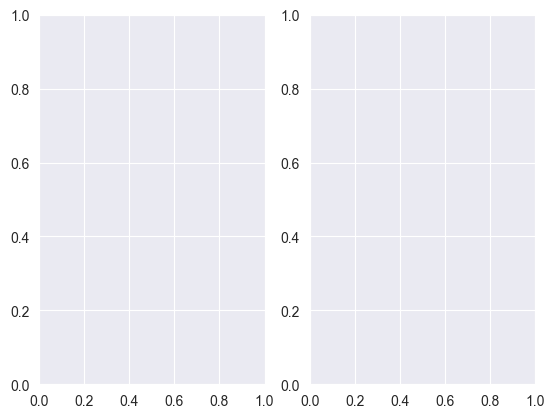

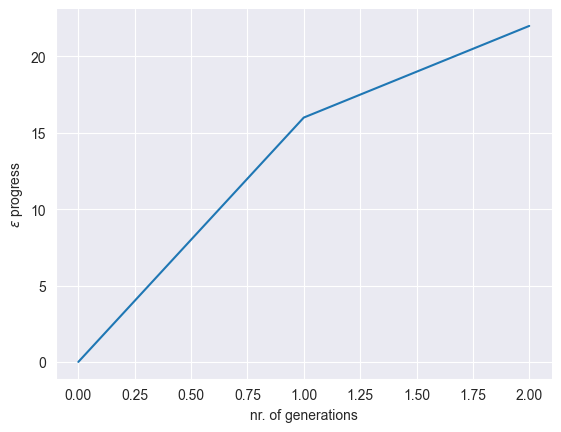

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel("nr. of generations")
ax1.set_ylabel(r"$\epsilon$ progress")
sns.despine()

[]

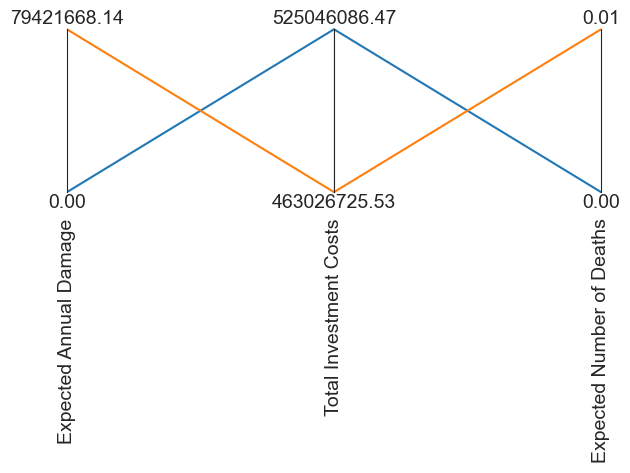

In [10]:
from ema_workbench.analysis import parcoords

outcomes = results.loc[:, list(dike_model.outcomes.keys())]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same
# axes.invert_axis('max_P')
plt.plot()